In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import os, sys

# src klasörünü path'e ekle
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.seq_utils import prepare_sequences


In [7]:
# Simüle edilmiş üretim hattı verisini okuyalım
df = pd.read_csv("../data/simulated/line_data.csv")
df.head()


,time,step,hour,shift_id,normal_queue,priority_queue,wip_total,completed_jobs,defect_rate,defects,...,machine_A_speed,machine_B_speed,machine_C_speed,maintenance_A,maintenance_B,maintenance_C,demand_spike_flag,queue_length,lead_time,machine_status
0,0.0,0,0,3,7.0,0.0,7.0,5,0.082489,0,...,2.319144,1.780925,1.178936,0,0,0,0,7.0,1.4,1.0
1,1.0,1,0,3,3.0,0.0,3.0,5,0.082611,0,...,2.166149,1.562310,0.929916,0,0,0,0,3.0,0.6,1.0
2,2.0,2,0,3,0.0,0.0,0.0,3,0.082709,0,...,1.997636,1.812255,1.099372,0,0,0,0,0.0,0.0,1.0
3,3.0,3,0,3,0.0,0.0,0.0,2,0.082782,0,...,2.066750,1.783581,1.280313,0,0,0,0,0.0,0.0,1.0
4,4.0,4,0,3,0.0,0.0,0.0,1,0.082828,0,...,1.892805,1.543757,1.344203,0,0,0,0,0.0,0.0,1.0


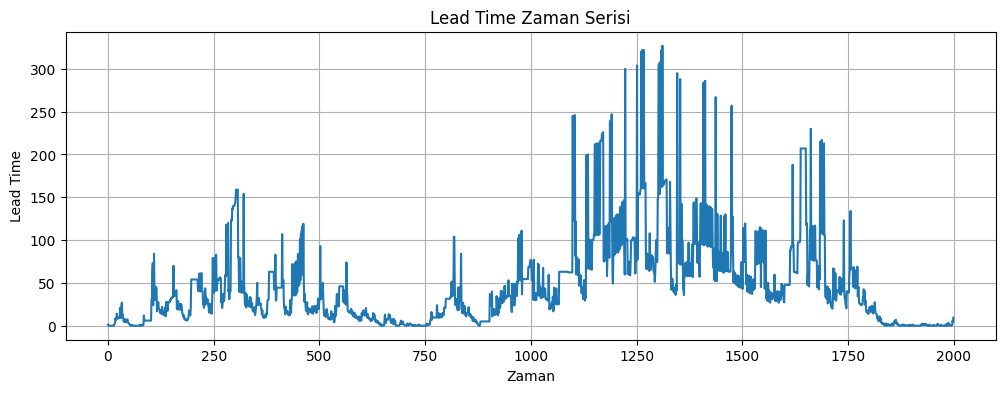

In [8]:
plt.figure(figsize=(12,4))
plt.plot(df["lead_time"])
plt.title("Lead Time Zaman Serisi")
plt.xlabel("Zaman")
plt.ylabel("Lead Time")
plt.grid()
plt.show()


In [9]:
# 1) lead_time serisini al
series = df["lead_time"].values.reshape(-1, 1)

# 2) Min-Max scaler ile [0,1] aralığına ölçekle
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series).flatten()

# 3) LSTM için sequence'ler (ölçeklenmiş seri)
X_scaled, y_scaled = prepare_sequences(series_scaled, window=10)

# 4) Aynı işlemi ölçeklenmemiş seri için de yap (gerçek değerleri karşılaştırmak için)
_, y_unscaled = prepare_sequences(series.flatten(), window=10)

X_scaled.shape, y_scaled.shape, y_unscaled.shape


((1990, 10), (1990,), (1990,))

In [10]:
# Veri setinin %80'i eğitim, %20'si test olsun
split_idx = int(len(X_scaled) * 0.8)

X_train = X_scaled[:split_idx]
y_train = y_scaled[:split_idx]

X_test  = X_scaled[split_idx:]
y_test_scaled = y_scaled[split_idx:]
y_test_true   = y_unscaled[split_idx:]   # gerçek (ölçeklenmemiş) hedef

X_train.shape, X_test.shape


((1592, 10), (398, 10))

In [12]:
! pip install tensorflow==2.16



ERROR: Could not find a version that satisfies the requirement tensorflow==2.16 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.16

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
from src.lstm_torch import create_lstm_torch

model = create_lstm_torch()
print(model)


LSTMRegressor(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [17]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None

    def should_stop(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            return False

        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False


In [22]:
import os, sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.seq_utils import prepare_sequences
from src.lstm_torch import create_lstm_torch


In [23]:
lead = df["lead_time"].values.astype(float)

X_np, y_np = prepare_sequences(lead, window=10)

X = torch.tensor(X_np, dtype=torch.float32).unsqueeze(-1)
y = torch.tensor(y_np, dtype=torch.float32)

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [34]:
model = create_lstm_torch()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()


In [35]:
train_losses = []
epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for batch_X, batch_y in loader:
        optimizer.zero_grad()
        pred = model(batch_X).squeeze()
        loss = loss_fn(pred, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    train_losses.append(avg_loss)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}")


Epoch 1/20 | Loss: 4516.1126
Epoch 2/20 | Loss: 4021.6077
Epoch 3/20 | Loss: 3672.5888
Epoch 4/20 | Loss: 3417.8867
Epoch 5/20 | Loss: 3185.5228
Epoch 6/20 | Loss: 3009.8681
Epoch 7/20 | Loss: 2830.4515
Epoch 8/20 | Loss: 2657.3548
Epoch 9/20 | Loss: 2518.1728
Epoch 10/20 | Loss: 2362.8098
Epoch 11/20 | Loss: 2247.4235
Epoch 12/20 | Loss: 2141.8399
Epoch 13/20 | Loss: 2072.8451
Epoch 14/20 | Loss: 1982.7746
Epoch 15/20 | Loss: 1874.8209
Epoch 16/20 | Loss: 1806.3035
Epoch 17/20 | Loss: 1761.5165
Epoch 18/20 | Loss: 1716.3444
Epoch 19/20 | Loss: 1609.6678
Epoch 20/20 | Loss: 1559.4171


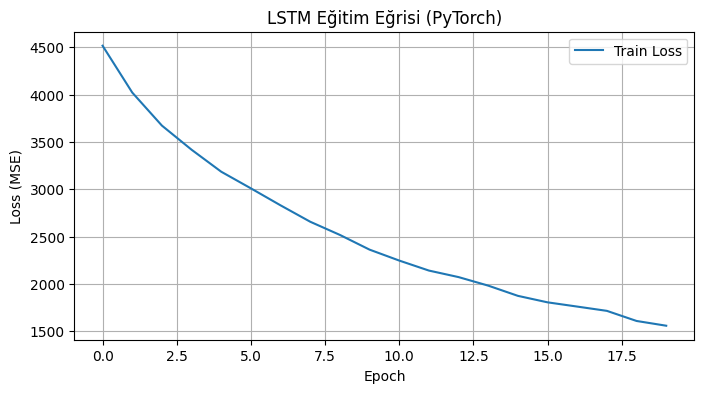

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("LSTM Eğitim Eğrisi (PyTorch)")
plt.grid()
plt.legend()
plt.show()


In [44]:
# ============================
# 1) TRAIN / TEST SPLIT
# ============================
# Örn: %80 train, %20 test
split_idx = int(len(X_np) * 0.8)

X_train_np = X_np[:split_idx]
y_train_np = y_np[:split_idx]

X_test_np  = X_np[split_idx:]
y_test_np  = y_np[split_idx:]

# Torch tensörleri
X_train = torch.tensor(X_train_np, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train_np, dtype=torch.float32)

X_test = torch.tensor(X_test_np, dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y_test_np, dtype=torch.float32)

# Dataloader
train_dataset = TensorDataset(X_train, y_train)
loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


# ============================
# 2) MODEL EĞİTİMİ (zaten çalışıyor)
# ============================
train_losses = []
epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in loader:
        optimizer.zero_grad()
        pred = model(batch_X).squeeze()
        loss = loss_fn(pred, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}")


# ============================
# 3) TEST SETİ İLE TAHMİN
# ============================
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test).squeeze().numpy()

# ============================
# 4) ORİJİNAL SKALA'YA GERİ ÇEVİR
# ============================
y_pred_unscaled = scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_test_true     = scaler.inverse_transform(y_test_np.reshape(-1,1)).flatten()

# ============================
# 5) MAPE / RMSE
# ============================
mape = mean_absolute_percentage_error(y_test_true, y_pred_unscaled)
rmse = np.sqrt(mean_squared_error(y_test_true, y_pred_unscaled))

mape, rmse


Epoch 1/20 | Loss: 1615.5528
Epoch 2/20 | Loss: 1562.9059
Epoch 3/20 | Loss: 1519.2615
Epoch 4/20 | Loss: 1482.0117
Epoch 5/20 | Loss: 1444.1030
Epoch 6/20 | Loss: 1411.0016
Epoch 7/20 | Loss: 1383.7511
Epoch 8/20 | Loss: 1351.3450
Epoch 9/20 | Loss: 1332.1331
Epoch 10/20 | Loss: 1314.8822
Epoch 11/20 | Loss: 1290.8114
Epoch 12/20 | Loss: 1265.5372
Epoch 13/20 | Loss: 1249.6599
Epoch 14/20 | Loss: 1223.0731
Epoch 15/20 | Loss: 1206.3941
Epoch 16/20 | Loss: 1184.3349
Epoch 17/20 | Loss: 1163.5675
Epoch 18/20 | Loss: 1145.5263
Epoch 19/20 | Loss: 1132.6861
Epoch 20/20 | Loss: 1117.6128


(2.3073665802719696e+17, 9633.09565448524)

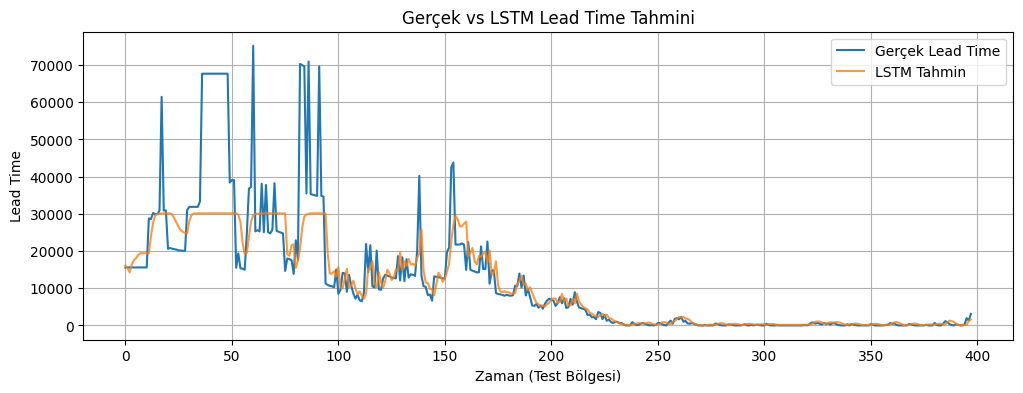

In [45]:
plt.figure(figsize=(12,4))
plt.plot(y_test_true, label="Gerçek Lead Time")
plt.plot(y_pred_unscaled, label="LSTM Tahmin", alpha=0.8)
plt.title("Gerçek vs LSTM Lead Time Tahmini")
plt.xlabel("Zaman (Test Bölgesi)")
plt.ylabel("Lead Time")
plt.legend()
plt.grid()
plt.show()


In [47]:
import os
import torch
import pickle

# modeller klasörü yoksa oluştur
os.makedirs("../models", exist_ok=True)

# ---------------------------
# 1) PyTorch LSTM modeli kaydetme
# ---------------------------
torch.save(model.state_dict(), "../models/lstm_lead_time.pt")

# ---------------------------
# 2) Scaler'ı pickle ile kaydedelim
# ---------------------------
with open("../models/lstm_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("PyTorch model ve scaler başarıyla kaydedildi.")


PyTorch model ve scaler başarıyla kaydedildi.


In [48]:
print(f"LSTM Test MAPE: {mape:.4f}")
print(f"LSTM Test RMSE: {rmse:.4f}")


LSTM Test MAPE: 230736658027196960.0000
LSTM Test RMSE: 9633.0957
